# Exploring the Relationship Between Crime-Prone Wards and Residential Housing Prices in London

In [1]:
# Import libraries and modules needed for the entire project
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.ticker import StrMethodFormatter
import scipy.stats as stats
from scipy.stats import kruskal
from sklearn.preprocessing import PolynomialFeatures
import re
import matplotlib.colors as mcolors
from matplotlib.ticker import StrMethodFormatter
from PIL import Image
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM

## 3.4 Merging the datasets

In [2]:
# Clean house price data - (1) remove local authority code from filtered_london_prices data
# Clean house price data - (2) make the house price values consistent, rounding all values to 2 decimal points(float)

# Change the 'Year ending Month Year' rows to 2008Q1 - 2023Q3
# Merge datasets based on names LookUp_BoroughName, WardName, WardCode
# For merged sets, we want each quarter row to show 2 information - house price, followed by n number of crime.

In [3]:
# Read CSVs
crime_data = pd.read_csv('final_cleaned_crime_data.csv')
house_prices = pd.read_csv('filtered_london_prices2.csv')

In [4]:
# Minor cleaning on house price data - remove local authority code for london_price data
house_prices.drop('Local authority code', axis=1, inplace=True, errors='ignore')
house_prices.head()

,LookUp_BoroughName,WardCode,WardName,Year ending Mar 2008,Year ending Jun 2008,Year ending Sep 2008,Year ending Dec 2008,Year ending Mar 2009,Year ending Jun 2009,Year ending Sep 2009,...,Year ending Dec 2020,Year ending Mar 2021,Year ending Jun 2021,Year ending Sep 2021,Year ending Dec 2021,Year ending Mar 2022,Year ending Jun 2022,Year ending Sep 2022,Year ending Dec 2022,Year ending Mar 2023
0,Barking and Dagenham,E05000026,Abbey,183503.53564,185865.28852,188033.36328,180628.23684,177795.41353,177714.01869,163750.24845,...,309508.93103,312335.92697,310880.89372,304485.19136,290932.10135,284981.86726,267432.26882,253508.16327,262482.75862,260524.39024
1,Barking and Dagenham,E05000027,Alibon,186748.62567,189166.93370,190668.52713,190602.40964,183746.26866,173877.77778,162602.08333,...,300084.82258,304196.55714,307583.43678,320589.59091,322403.96341,332452.16049,336012.77612,335426.39655,354198.69355,349081.49057
2,Barking and Dagenham,E05000033,Goresbrook,192907.22973,187726.92233,183495.58710,179071.50000,167569.40000,155868.77049,151743.68056,...,296573.53571,296298.43750,305795.79012,307588.30337,312029.86076,328703.80882,339093.75000,353587.71930,364150.79365,360784.48276
3,Barking and Dagenham,E05000030,Eastbrook,214166.83654,215914.80000,210896.36364,212247.64151,205984.85897,197469.53030,185738.89744,...,359260.15238,371028.15741,382167.25197,395369.04762,404314.61538,406768.12500,408358.92857,414048.92857,408422.03488,406553.68750
4,Barking and Dagenham,E05000036,Mayesbrook,190229.47236,192776.84848,189357.10938,194160.00000,186767.83019,176199.36364,163378.76923,...,315524.27419,316809.18182,331721.22727,339602.18841,347399.15625,366254.55385,363057.50000,375442.02899,371310.60606,369389.83051


In [5]:
# Function to map the old column names to the Year-Quarter format
def map_column_names(old_col_name):
# Create a dictionary mapping old month-year to quarter-year
    month_to_quarter = {'Mar': 'Q1', 'Jun': 'Q2', 'Sep': 'Q3', 'Dec': 'Q4'}
    parts = old_col_name.split(' ')

    # Check if the column name is in the expected format with at least two parts
    if len(parts) >= 3 and parts[1] == 'ending':
        month = parts[2]
        year = parts[3]
        quarter = month_to_quarter.get(month, None)
        if quarter:
            return f'{year}{quarter}'
    return old_col_name # Return the old name if it doesn't match the pattern

# Assuming 'house_prices' is the DataFrame with your house price data
# Apply the function to each column name
house_prices.columns = [map_column_names(col) for col in house_prices.columns]

# Check updated column names to verify
print(house_prices.columns)

Index(['LookUp_BoroughName', 'WardCode', 'WardName', '2008Q1', '2008Q2',
       '2008Q3', '2008Q4', '2009Q1', '2009Q2', '2009Q3', '2009Q4', '2010Q1',
       '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4',
       '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2', '2013Q3',
       '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4', '2015Q1', '2015Q2',
       '2015Q3', '2015Q4', '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1',
       '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
       '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3',
       '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2',
       '2022Q3', '2022Q4', '2023Q1'],
      dtype='object')


In [6]:
# Convert only quarter columns to numeric, coercing non-numeric types to NaN
quarter_columns = [col for col in house_prices.columns if 'Q' in col] # Adjust if necessary

for column in quarter_columns:
    house_prices[column] = pd.to_numeric(house_prices[column], errors='coerce')

# Apply rounding only to these quarter columns
for column in quarter_columns:
    house_prices[column] = house_prices[column].round(2)

# Check if the non-numeric columns are still intact
print(house_prices[['LookUp_BoroughName', 'WardCode', 'WardName']].head())

     LookUp_BoroughName   WardCode    WardName
0  Barking and Dagenham  E05000026       Abbey
1  Barking and Dagenham  E05000027      Alibon
2  Barking and Dagenham  E05000033  Goresbrook
3  Barking and Dagenham  E05000030   Eastbrook
4  Barking and Dagenham  E05000036  Mayesbrook


In [7]:
# Merge datasets based on LookUp_BoroughName, WardName, WardCode
# Ensure that the column names used for merging are consistent across both dataframes
merged_data = pd.merge(house_prices, crime_data, left_on =['LookUp_BoroughName', 'WardCode', 'WardName'],
                       right_on =['LookUp_BoroughName', 'WardCode', 'WardName'],how = 'inner')

In [8]:
# Drop 2023Q2 and 2023Q3 data as the house_price dataset didnt have the values up till that point
# to be consistent, 2008Q1 - 2023Q1
merged_data.drop(columns = ['2023Q2', '2023Q3'], errors ='ignore', inplace = True)

In [9]:
merged_data.head()

,LookUp_BoroughName,WardCode,WardName,2008Q1_x,2008Q2_x,2008Q3_x,2008Q4_x,2009Q1_x,2009Q2_x,2009Q3_x,...,2020Q4_y,2021Q1_y,2021Q2_y,2021Q3_y,2021Q4_y,2022Q1_y,2022Q2_y,2022Q3_y,2022Q4_y,2023Q1_y
0,Barking and Dagenham,E05000026,Abbey,183503.54,185865.29,188033.36,180628.24,177795.41,177714.02,163750.25,...,486.0,445.0,483.0,534.0,555.0,579.0,515.0,549.0,540.0,578.0
1,Barking and Dagenham,E05000027,Alibon,186748.63,189166.93,190668.53,190602.41,183746.27,173877.78,162602.08,...,168.0,144.0,213.0,224.0,200.0,227.0,183.0,218.0,172.0,176.0
2,Barking and Dagenham,E05000033,Goresbrook,192907.23,187726.92,183495.59,179071.50,167569.40,155868.77,151743.68,...,322.0,247.0,339.0,288.0,327.0,302.0,303.0,307.0,350.0,393.0
3,Barking and Dagenham,E05000030,Eastbrook,214166.84,215914.80,210896.36,212247.64,205984.86,197469.53,185738.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Barking and Dagenham,E05000036,Mayesbrook,190229.47,192776.85,189357.11,194160.00,186767.83,176199.36,163378.77,...,260.0,225.0,259.0,238.0,225.0,252.0,254.0,239.0,309.0,282.0


In [10]:
# Reformat the dataset so that for each quarter shows price and crime next to one another.
# x represents price whereas crime is y
# this is solely for readibility only

In [11]:
# Step 1: Rename the columns
merged_data.rename(columns=lambda x: x.replace('_x', '_price').replace('_y', '_crime'), inplace=True)

# Step 2: Extract the years and quarters from the column names
year_quarters = set(col.rsplit('_', 1)[0] for col in merged_data.columns if 'price' in col or 'crime' in col)

# Prepare the new column order, starting with 'LookUp_BoroughName', 'WardCode', and 'WardName'
new_columns = ['LookUp_BoroughName', 'WardCode', 'WardName']

# Add the price and crime columns in the desired order
for yq in sorted(year_quarters):
    if f'{yq}_price' in merged_data.columns and f'{yq}_crime' in merged_data.columns:
        new_columns.extend([f'{yq}_price', f'{yq}_crime'])

# Include any remaining columns that haven't been added yet
new_columns.extend(col for col in merged_data.columns if col not in new_columns)

# Reindex the DataFrame with the new column order
merged_data_final = merged_data[new_columns]

In [12]:
merged_data_final.head()

,LookUp_BoroughName,WardCode,WardName,2008Q1_price,2008Q1_crime,2008Q2_price,2008Q2_crime,2008Q3_price,2008Q3_crime,2008Q4_price,...,2022Q1_price,2022Q1_crime,2022Q2_price,2022Q2_crime,2022Q3_price,2022Q3_crime,2022Q4_price,2022Q4_crime,2023Q1_price,2023Q1_crime
0,Barking and Dagenham,E05000026,Abbey,183503.54,828.0,185865.29,863.0,188033.36,836.0,180628.24,...,284981.87,579.0,267432.27,515.0,253508.16,549.0,262482.76,540.0,260524.39,578.0
1,Barking and Dagenham,E05000027,Alibon,186748.63,258.0,189166.93,222.0,190668.53,230.0,190602.41,...,332452.16,227.0,336012.78,183.0,335426.40,218.0,354198.69,172.0,349081.49,176.0
2,Barking and Dagenham,E05000033,Goresbrook,192907.23,221.0,187726.92,235.0,183495.59,254.0,179071.50,...,328703.81,302.0,339093.75,303.0,353587.72,307.0,364150.79,350.0,360784.48,393.0
3,Barking and Dagenham,E05000030,Eastbrook,214166.84,240.0,215914.80,210.0,210896.36,199.0,212247.64,...,406768.12,0.0,408358.93,0.0,414048.93,0.0,408422.03,0.0,406553.69,0.0
4,Barking and Dagenham,E05000036,Mayesbrook,190229.47,239.0,192776.85,260.0,189357.11,231.0,194160.00,...,366254.55,252.0,363057.50,254.0,375442.03,239.0,371310.61,309.0,369389.83,282.0


In [13]:
# Save to CSV
merged_data_final.to_csv('merged_data_final.csv', index=False)
merged_data = pd.read_csv('merged_data_final.csv')

### 3.5 Dealing with '0' values

To enhance the analytical robustness, we conducted a preliminary data refinement by excluding rows with more than nine zero values, focusing on those containing nine or fewer zeros. Subsequently, we isolated the 'crime' columns, computed rounded means for each row, and replaced zero values with their respective means to bolster precision. The refined dataset, denoted as 'merged_data_filtered,' presents the initial rows with updated values, thereby improving the clarity and interpretability of the dataset.

In [14]:
# For wards with more than half of the crime count not recorded, we remove from our test
# For wards with less than half of the crime count recorded, we replace the 0's with an average value
# Count the number of columns with a value of 0 in each row
count_zero_columns = (merged_data == 0).sum(axis=1)

# Filter rows where the count is less than or equal to 9
# If the row contains the 0 value for more than 9 quarters, it is removed
merged_data_filtered = merged_data[count_zero_columns <= 9]

# Extract column names that end with 'crime'
columns_with_crime = [col for col in merged_data_filtered.columns if col.endswith('crime')]

# Calculate the rounded average for each row for the selected crime columns
rounded_average_per_row = merged_data_filtered[columns_with_crime].mean(axis=1).round().astype(int)

# Replace 0 values in crime columns with the corresponding rounded average values
for col in columns_with_crime:
    merged_data_filtered.loc[merged_data_filtered[col] == 0, col] = rounded_average_per_row

# Display the resulting DataFrame with replaced values
merged_data_filtered.head()

,LookUp_BoroughName,WardCode,WardName,2008Q1_price,2008Q1_crime,2008Q2_price,2008Q2_crime,2008Q3_price,2008Q3_crime,2008Q4_price,...,2022Q1_price,2022Q1_crime,2022Q2_price,2022Q2_crime,2022Q3_price,2022Q3_crime,2022Q4_price,2022Q4_crime,2023Q1_price,2023Q1_crime
0,Barking and Dagenham,E05000026,Abbey,183503.54,828.0,185865.29,863.0,188033.36,836.0,180628.24,...,284981.87,579.0,267432.27,515.0,253508.16,549.0,262482.76,540.0,260524.39,578.0
1,Barking and Dagenham,E05000027,Alibon,186748.63,258.0,189166.93,222.0,190668.53,230.0,190602.41,...,332452.16,227.0,336012.78,183.0,335426.40,218.0,354198.69,172.0,349081.49,176.0
2,Barking and Dagenham,E05000033,Goresbrook,192907.23,221.0,187726.92,235.0,183495.59,254.0,179071.50,...,328703.81,302.0,339093.75,303.0,353587.72,307.0,364150.79,350.0,360784.48,393.0
4,Barking and Dagenham,E05000036,Mayesbrook,190229.47,239.0,192776.85,260.0,189357.11,231.0,194160.00,...,366254.55,252.0,363057.50,254.0,375442.03,239.0,371310.61,309.0,369389.83,282.0
5,Barking and Dagenham,E05000029,Chadwell Heath,208404.86,300.0,209918.42,284.0,207978.62,289.0,196762.03,...,367213.47,266.0,378425.30,308.0,381839.93,272.0,385279.17,305.0,392515.09,262.0


In [15]:
csv_filename = 'merged_data_filtered.csv'
merged_data_filtered.to_csv(csv_filename, index=False)

## 4. Exploratory Data Analysis

In [16]:
# To assess whether there is a crime-price relationship, we must first explore our data
# By including a long term analysis (15 years), we account for wider economic downturns that may offset findigs
# The recent trends show the last 5 years

# Extract columns for the 2008-2023 and 2018-2023 periods
price_columns_2008_to_2023 = [f'{year}Q{quarter}_price' for year in range(2008, 2023) for quarter in range(1, 5)]
crime_columns_2008_to_2023 = [f'{year}Q{quarter}_crime' for year in range(2008, 2023) for quarter in range(1, 5)]
price_columns_2018_to_2023 = [f'{year}Q{quarter}_price' for year in range(2018, 2023) for quarter in range(1, 5)]
crime_columns_2018_to_2023 = [f'{year}Q{quarter}_crime' for year in range(2018, 2023) for quarter in range(1, 5)]

# Calculate the average price for the 2008-2023 and 2018-2023 periods
average_price_2008_to_2023 = merged_data_filtered[price_columns_2008_to_2023].mean(axis=1).astype(int)
average_price_2018_to_2023 = merged_data_filtered[price_columns_2018_to_2023].mean(axis=1).astype(int)

# Calculate the average crime for the 2008-2023 and 2018-2023 periods
average_crime_2008_to_2023 = merged_data_filtered[crime_columns_2008_to_2023].mean(axis=1).astype(int)
average_crime_2018_to_2023 = merged_data_filtered[crime_columns_2018_to_2023].mean(axis=1).astype(int)

# Create a new DataFrame to store the results
average_data = pd.DataFrame({
    'LookUp_BoroughName': merged_data_filtered['LookUp_BoroughName'],
    'WardCode': merged_data_filtered['WardCode'],
    'WardName': merged_data_filtered['WardName'],
    'LT_Average_Price_(2008-2023)': average_price_2008_to_2023,
    'LT_Average_Crime_(2008-2023)': average_crime_2008_to_2023,
    'ST_Average_Price_(2018-2023)': average_price_2018_to_2023,
    'ST_Average_Crime_(2018-2023)': average_crime_2018_to_2023
    })

# Display the resulting DataFrame with calculated averages and additional columns
average_data.head()

,LookUp_BoroughName,WardCode,WardName,LT_Average_Price_(2008-2023),LT_Average_Crime_(2008-2023),ST_Average_Price_(2018-2023),ST_Average_Crime_(2018-2023)
0,Barking and Dagenham,E05000026,Abbey,219825,561,275759,525
1,Barking and Dagenham,E05000027,Alibon,235638,192,312429,195
2,Barking and Dagenham,E05000033,Goresbrook,230907,281,303834,302
4,Barking and Dagenham,E05000036,Mayesbrook,242856,240,321749,254
5,Barking and Dagenham,E05000029,Chadwell Heath,262957,261,349124,272


In [17]:
# Determine the LT and ST changes for crime-price relationship
# Calculate the overall average price and crime for the 2013-2023 and 2018-2023 periods
overall_average_price_2008_to_2023 = merged_data_filtered[price_columns_2008_to_2023].mean().mean().astype(int)
overall_average_price_2018_to_2023 = merged_data_filtered[price_columns_2018_to_2023].mean().mean().astype(int)
overall_average_crime_2008_to_2023 = merged_data_filtered[crime_columns_2008_to_2023].mean().mean().astype(int)
overall_average_crime_2018_to_2023 = merged_data_filtered[crime_columns_2018_to_2023].mean().mean().astype(int)

# Create a new DataFrame to store the overall averages
overall_average_data = pd.DataFrame({
'LT_Average_Price_(2008-2023)': overall_average_price_2008_to_2023,
'LT_Average_Crime_(2008-2023)': overall_average_crime_2008_to_2023,
'ST_Average_Price_(2018-2023)': overall_average_price_2018_to_2023,
'ST_Average_Crime_(2018-2023)': overall_average_crime_2018_to_2023
},index=['London'])

# Display the resulting DataFrame with overall London averages
overall_average_data

,LT_Average_Price_(2008-2023),LT_Average_Crime_(2008-2023),ST_Average_Price_(2018-2023),ST_Average_Crime_(2018-2023)
London,490483,305,619546,318


This statistical analysis highlights that the London average price has steadily increased to £490,483 over the last 15 years, while the
average crime number remained stable at approximately 305 incidents. However, house prices continued to increase to a mean of £619,546
in the last five years, while the average crime rate remained constant at around 318 incidents. This indicates a sustained increase in prices
(26.31%) without a significant impact on crime rates (4.26%).

In [18]:
# Asses the % change in prices and crime levels across London (background for analysis)
# Calculate %change for average house paid prices
percentage_change_price = ((overall_average_data['ST_Average_Price_(2018-2023)'] - overall_average_data['LT_Average_Price_(2008-2023)']))

                            # Calculate %change for average crime numbers
percentage_change_crime = ((overall_average_data['ST_Average_Crime_(2018-2023)'] - overall_average_data['LT_Average_Crime_(2008-2023)']))

# Create a new DF that stores the %changes
percentage_change_data = pd.DataFrame({
    'Percentage Change Price %': percentage_change_price,
    'Percentage Change Crime %': percentage_change_crime
}, index =['London'])
                      
# Show the two %changes relevant to our analysis
percentage_change_data

,Percentage Change Price %,Percentage Change Crime %
London,129063,13


## 5. Data Visualisations

Given our statistical analysis results, the ward-level data on price paid and crime was aggregated to the borough scale for more insightful
first-hand business observations. But first, two preliminary graphs were generated to illustrate the overall London patterns.

### 5.1 London-wide Trends

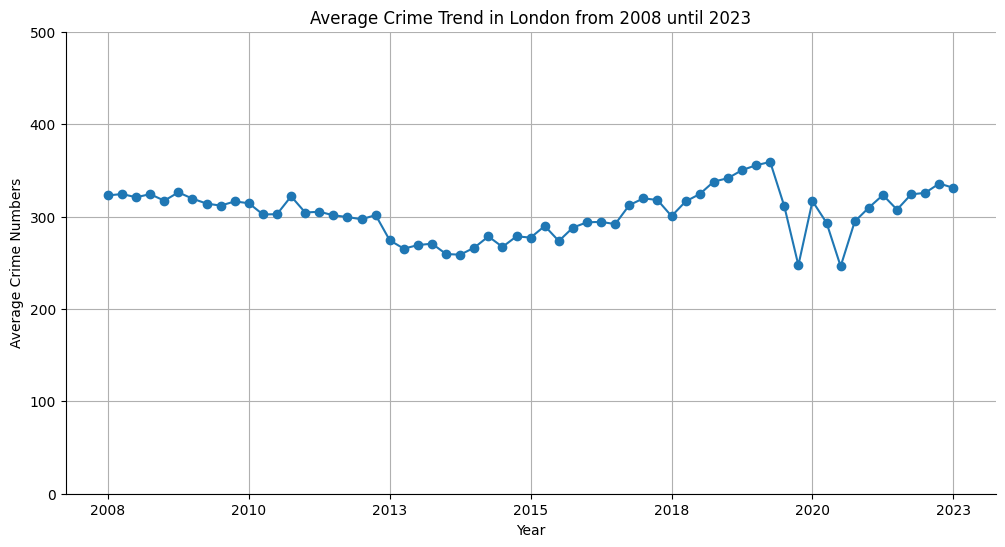

In [19]:
# Plot the average London crime numbers to observe general trends
# Extract columns with crime levels
crime_columns = [col for col in merged_data_filtered.columns if col.endswith('_crime')]

# Extract relevant columns (LookUp_BoroughName and crime columns)
selected_columns = ['LookUp_BoroughName'] + crime_columns
selected_data = merged_data_filtered[selected_columns]

# Group by borough and calculate the average crime level for each borough
average_crime_by_borough = selected_data.groupby('LookUp_BoroughName').mean()
average_crime_by_borough_transposed = average_crime_by_borough.transpose()

# Aggregate all London boroughs
london_crime = average_crime_by_borough.mean(axis = 0)

# Transpose the DataFrame for better visualisation
london_crime_transposed = london_crime.transpose()

# Extract years from column names
years = [col.split('_')[0] for col in london_crime.index]
london_crime.index = years #Set the index to only show years

# Plot the average crime levels
ax = london_crime.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Average Crime Trend in London from 2008 until 2023')
plt.xlabel('Year')
plt.ylabel('Average Crime Numbers')
plt.grid(True)
sns.despine()

# Set y-axis range between 0 and 500
ax.set_ylim([0, 500])

# Format y-axis labels as integers
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Format x-axis labels to remove quarters
ax.set_xticklabels([label.get_text().split('Q')[0] for label in ax.get_xticklabels()])
plt.show()

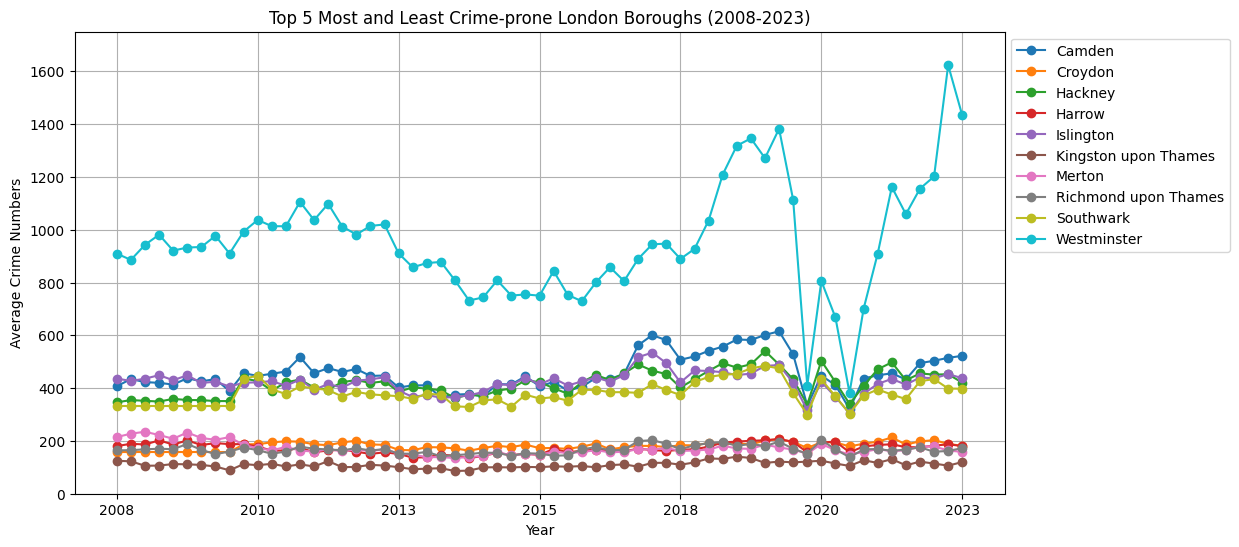

In [20]:
# Because the overall London trend lacks depth, we move to a more granular analysis
# So, we plot the average London crime for top 5 most and least criminalised boroughs for granularity
# Extract columns with crime levels
crime_columns = [col for col in merged_data_filtered.columns if col.endswith('_crime')]

# Extract relevant columns (LookUp_BoroughName and crime columns)
selected_columns = ['LookUp_BoroughName'] + crime_columns
selected_data = merged_data_filtered[selected_columns]

# Sort boroughs based on average crime levels
sorted_boroughs = average_crime_by_borough.mean(axis = 1).sort_values()

# Select the top and bottom 5 boroughs for more insightful analysis
selected_boroughs = sorted_boroughs.head(5).index.tolist() + sorted_boroughs.tail(5).index.tolist()

# Filter the data to only include the selected boroughs
filtered_data = selected_data[selected_data['LookUp_BoroughName'].isin(selected_boroughs)]

# Group by borough and calculate the average crime level for each borough
average_crime_by_selected_borough = filtered_data.groupby('LookUp_BoroughName').mean()

# Transpose the DataFrame for better visualization
average_crime_by_borough_transposed = average_crime_by_selected_borough.transpose()

# Extract years from column names
years =[col.split('_')[0] for col in average_crime_by_borough_transposed.index]
average_crime_by_borough_transposed.index = years # Set the index to only show years

# Get a list of distinct colors for each borough from the TABLEAU_COLORS
num_colors = 10
colors = list(TABLEAU_COLORS.values())[:num_colors]

# Plot the average crime levels
ax = average_crime_by_borough_transposed.plot(kind='line',
                                              marker='o',
                                              figsize=(12,6),
                                              color=colors)

# Move the legend to the right outside the plot
ax.legend(bbox_to_anchor=(1,1),loc = 'upper left')

plt.title('Top 5 Most and Least Crime-prone London Boroughs (2008-2023)')
plt.xlabel('Year')
plt.ylabel('Average Crime Numbers')
plt.grid(True)

# Set y-axis range between 0 and 1750
ax.set_ylim([0,1750])

# Format x-axis labels to remove quarters
ax.set_xticklabels([label.get_text().split('Q')[0] for label in ax.get_xticklabels()])
plt.show()


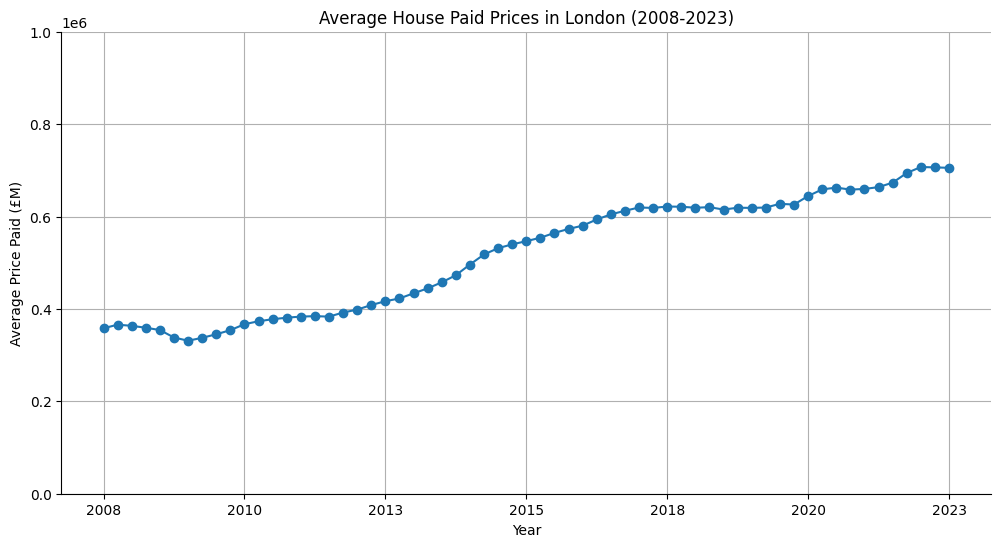

In [21]:
# Similarly, plot the average London house price paid numbers to see general trends
# Extract columns with prices
price_columns = [col for col in merged_data_filtered.columns if col.endswith('_price')]

# Extract relevant columns (LookUp_BoroughName and price columns)
selected_columns = ['LookUp_BoroughName'] + price_columns
selected_data = merged_data_filtered[selected_columns]

# Group by borough and calculate the average price for each borough
average_prices_by_borough = selected_data.groupby('LookUp_BoroughName').mean()

# Aggregate all London boroughs
london_boroughs = average_prices_by_borough.mean(axis=0)

# Transpose the DataFrame for better visualization
average_prices_by_borough_transposed = london_boroughs.transpose()

# Plot the average prices for London between 2008 and 2023
london_prices = london_boroughs

# Extract years from column names
years =[col.split('_')[0] for col in london_prices.index]
london_prices.index = years #Set the index to only show years

ax = london_prices.plot(kind = 'line',
                        marker = 'o',
                        figsize = (12,6))
plt.title('Average House Paid Prices in London (2008-2023)')
plt.xlabel('Year')
plt.ylabel('Average Price Paid (£M)')
plt.grid(True)
sns.despine()

# Format x-axis labels to remove quarters for readability
ax.set_xticklabels([label.get_text().split('Q')[0] for label in ax.get_xticklabels()])

# Set y-axis range between 0 and 1,000,000 (£)
ax.set_ylim([0,1000000])

plt.show()

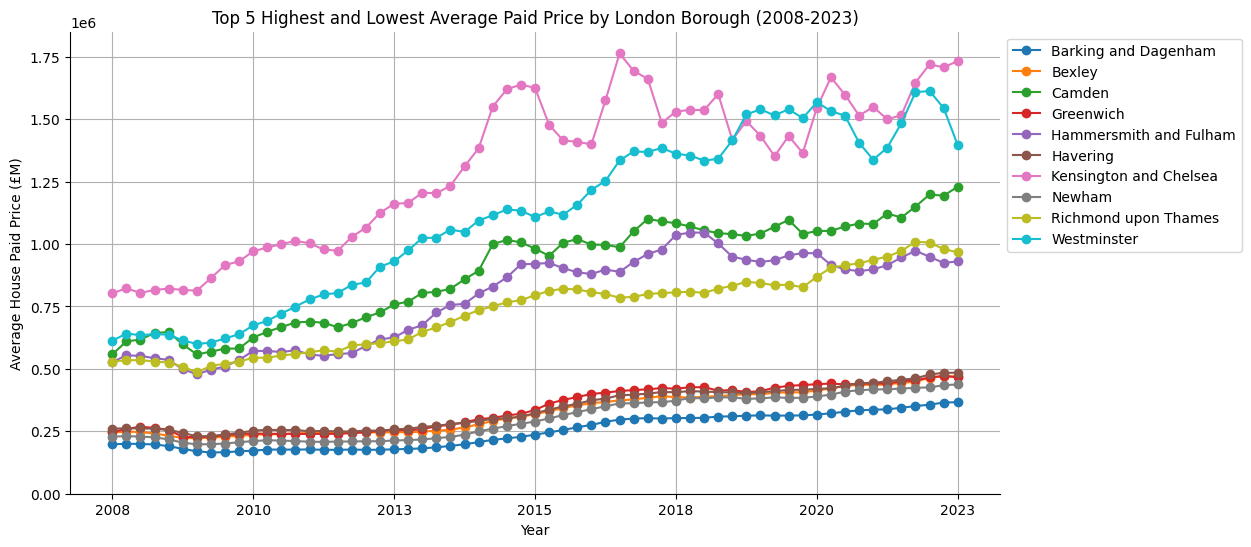

In [22]:
# Because the overall London trend lacks depth, we move to a more granular analysis
# So, we plot the average London house price paid for top 5 most and least expensive boroughs for granularity
# Extract columns with prices
price_columns = [col for col in merged_data_filtered.columns if col.endswith('_price')]

# Extract relevant columns (LookUp_BoroughName and price columns)
selected_columns = ['LookUp_BoroughName'] + price_columns
selected_data = merged_data_filtered[selected_columns]

# Sort all London boroughs based on average house paid price to then select the top 5 most and least expensive ones
sorted_boroughs_prices = average_prices_by_borough.mean(axis=1).sort_values()
selected_boroughs_prices = sorted_boroughs_prices.head(5).index.tolist() + sorted_boroughs_prices.tail(5).index.tolist()

# Filter the selected data to only display the 10 relevant boroughs
filter_data_prices = selected_data[selected_data['LookUp_BoroughName'].isin(selected_boroughs_prices)]

# Group boroughs and calculate their average paid price
average_prices_by_selected_borough = filter_data_prices.groupby('LookUp_BoroughName').mean()

# Transpose data for better visualization
average_prices_by_selected_borough_transposed = average_prices_by_selected_borough.transpose()

# Extract years from column names
years = [col.split('_')[0] for col in average_prices_by_selected_borough_transposed.index]

average_prices_by_selected_borough_transposed.index = years #Set the index to only show years

# Plot the average price trend
ax = average_prices_by_selected_borough_transposed.plot(kind = 'line',
                                                   marker = 'o',
                                                   figsize = (12,6))
plt.title('Top 5 Highest and Lowest Average Paid Price by London Borough (2008-2023)')
plt.xlabel('Year')
plt.ylabel('Average House Paid Price (£M)')
plt.grid(True)
sns.despine()

# Set y-axis range between 0 and 1,850,000 (£)
ax.set_ylim([0,1850000])

# Format x-axis labels to remove quarters for readability
ax.set_xticklabels([label.get_text().split('Q')[0] for label in ax.get_xticklabels()])

# Move the legend to the right so that it does not cover the plot
ax.legend(bbox_to_anchor=(1,1),loc = 'upper left')

plt.show()

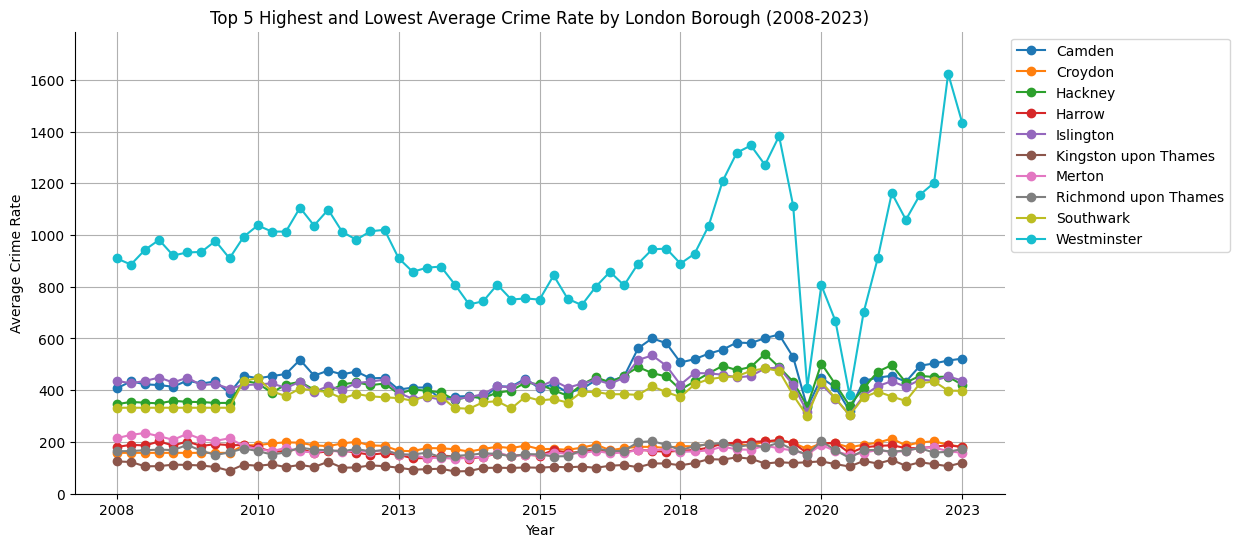

In [23]:
# Extract columns with crime data
crime_columns = [col for col in merged_data_filtered.columns if col.endswith('_crime')]

# Extract relevant columns (LookUp_BoroughName and crime columns)
selected_columns = ['LookUp_BoroughName'] + crime_columns
selected_data = merged_data_filtered[selected_columns]

# Sort all London boroughs based on average crime rate to then select the top 5 most and least crime-prone ones
sorted_boroughs_crime = average_crime_by_borough.mean(axis=1).sort_values()
selected_boroughs_crime = sorted_boroughs_crime.head(5).index.tolist() + sorted_boroughs_crime.tail(5).index.tolist()

# Filter the selected data to only display the 10 relevant boroughs
filter_data_crime = selected_data[selected_data['LookUp_BoroughName'].isin(selected_boroughs_crime)]

# Group boroughs and calculate their average crime rate
average_crime_by_selected_borough = filter_data_crime.groupby('LookUp_BoroughName').mean()

# Transpose data for better visualization
average_crime_by_selected_borough_transposed = average_crime_by_selected_borough.transpose()

# Extract years from column names
years = [col.split('_')[0] for col in average_crime_by_selected_borough_transposed.index]
average_crime_by_selected_borough_transposed.index = years # Set the index to only show years

# Plot the average crime trend
ax = average_crime_by_selected_borough_transposed.plot(kind = 'line', 
                                                       marker = 'o', 
                                                       figsize = (12,6))
plt.title('Top 5 Highest and Lowest Average Crime Rate by London Borough (2008-2023)')
plt.xlabel('Year')
plt.ylabel('Average Crime Rate')
plt.grid(True)
sns.despine()

# Set y-axis range between 0 and a higher limit
higher_y_limit = average_crime_by_selected_borough_transposed.max().max() * 1.1 # Adjust the multiplier as needed
ax.set_ylim([0,higher_y_limit])

# Format x-axis labels to remove quarters for readability
ax.set_xticklabels([label.get_text().split('Q')[0] for label in ax.get_xticklabels()])

# Move the legend to the right so that it does not cover the plot
ax.legend(bbox_to_anchor = (1,1), loc = 'upper left')

plt.show()

### 5.2 Trend Analysis 1: Safest Borough

In [24]:
# Find the London Borough with the lowest crime levels
# Extract columns with crime levels
crime_columns = [col for col in merged_data_filtered.columns if col.endswith('_crime')]

# Extract relevant columns (LookUp_BoroughName and crime columns)
selected_columns = ['LookUp_BoroughName'] + crime_columns
selected_data = merged_data_filtered[selected_columns]

# Group by borough and calculate the average crime level for each borough
average_crime_by_borough = selected_data.groupby('LookUp_BoroughName').mean()

# Calculate the mean crime level across all crime columns for each borough
average_crime_by_borough['AverageCrime'] = average_crime_by_borough.mean(axis=1)

# Find the borough with the lowest average crime level
borough_with_lowest_crime = average_crime_by_borough['AverageCrime'].idxmin()
print(f"The borough with the lowest average crime level is: {borough_with_lowest_crime}")

The borough with the lowest average crime level is: Kingston upon Thames


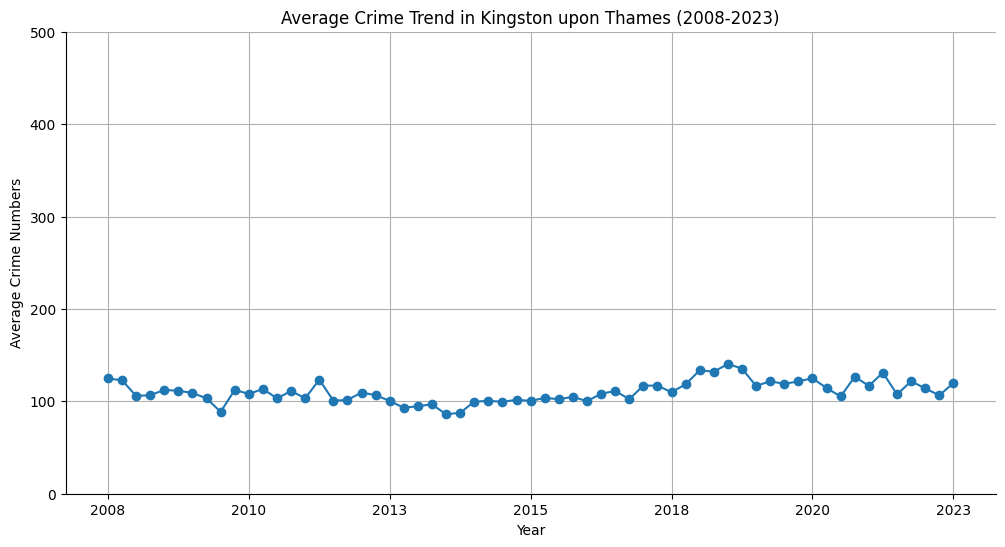

In [25]:
# Plot the average crime numbers for Kingston upon Thames between 2008 and 2023
kingston_upon_Thames_crime = average_crime_by_borough_transposed['Kingston upon Thames']

# Extract years from column names
years = [col.split('_')[0] for col in kingston_upon_Thames_crime.index]
kingston_upon_Thames_crime.index = years #Set the index to only show years

# Plot the average crime levels
ax = kingston_upon_Thames_crime.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Average Crime Trend in Kingston upon Thames (2008-2023)')
plt.xlabel('Year')
plt.ylabel('Average Crime Numbers')
plt.grid(True)
sns.despine()

# Set y-axis range between 0 and 500
ax.set_ylim([0, 500])

# Format y-axis labels as integers
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Format x-axis labels to remove quarters for readability
ax.set_xticklabels([label.get_text().split('Q')[0] for label in ax.get_xticklabels()])
plt.show()

In [26]:
# Plot the average prices for Kingston upon Thames between 2008 and 2023
kingston_upon_Thames_prices = average_prices_by_borough_transposed['Kingston upon Thames']

# Extract years from column names
years = [col.split('_')[0] for col in kingston_upon_Thames_prices.index]
kingston_upon_Thames_prices.index = years # Set the index to show years

# Plot the average prices with y-axis range between 0 and 1,000,000
ax = kingston_upon_Thames_prices.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Average Prices in Kingston upon Thames (2008-2023)')
plt.xlabel('Year')
plt.ylabel('Average Price (£)')
plt.grid(True)
sns.despine()

# Set y-axis range between 0 and 1,000,000
ax.set_ylim([0,1000000])

# Format y-axis labels as integers
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Format x-axis labels to remove quarters
ax.set_xticklabels([label.get_text().split('Q')[0] for label in ax.get_xticklabels()])
plt.show()

KeyError: 'Kingston upon Thames'

The resulting charts unveils captivating patterns featuring a prevalent upward trajectory in both prices and crime rates. Notably, housing
prices exhibit a more consistent climb. The chart also brings attention to distinct peaks and troughs in crime, with a significant spike
observed around 2019, followed by a marked decline.

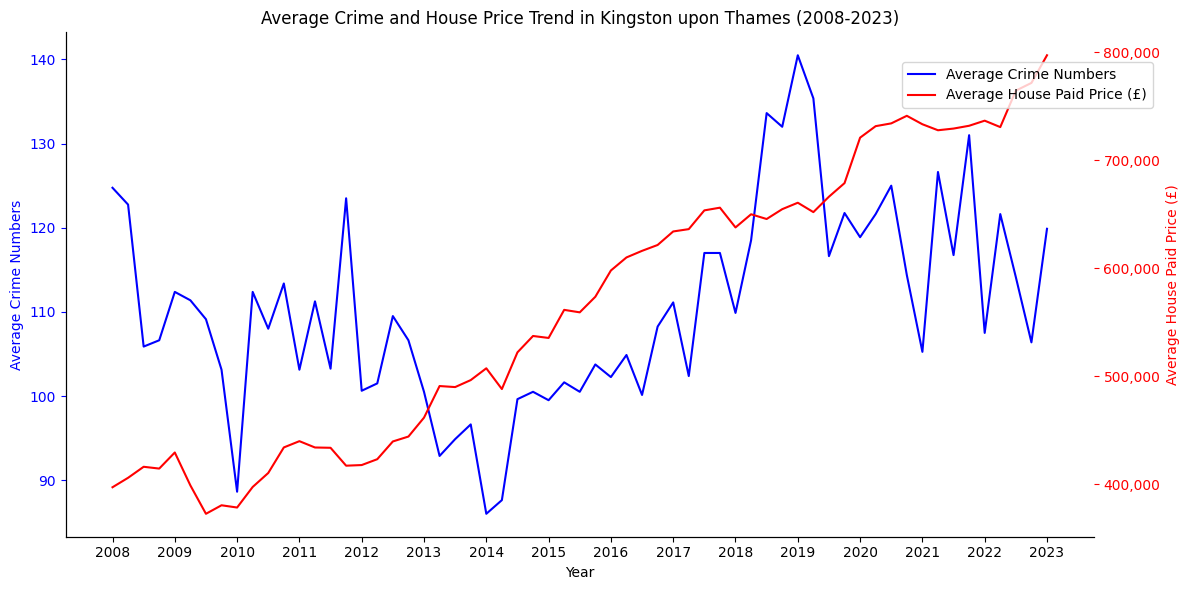

In [29]:
# Then, combine the two visualizations to observe matching patterns

# Extract columns with prices
price_columns = [col for col in merged_data_filtered.columns if col.endswith('_price')]

# Extract columns with crime levels
crime_columns = [col for col in merged_data_filtered.columns if col.endswith('_crime')]

# Extract relevant columns (LookUp_BoroughName, price columns, and crime columns)
selected_columns = ['LookUp_BoroughName'] + price_columns + crime_columns
selected_data = merged_data_filtered[selected_columns]

# Filter data for Kingston upon Thames
kingston_upon_thames_data = selected_data[selected_data['LookUp_BoroughName'] == 'Kingston upon Thames']

# Plot both average crime levels and average prices on one graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average crime levels on the primary y-axis
ax1.plot(
    kingston_upon_thames_data[crime_columns].columns.str.split('_').str[0],
    kingston_upon_thames_data[crime_columns].mean(), 
    color='b', label='Average Crime Numbers'
)
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Crime Numbers', color='b')
ax1.tick_params('y', colors='b')
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Create a secondary y-axis for average prices
ax2 = ax1.twinx()
ax2.plot(
    kingston_upon_thames_data[price_columns].columns.str.split('_').str[0],
    kingston_upon_thames_data[price_columns].mean(), 
    color='r', label='Average House Paid Price (£)'
)
ax2.set_ylabel('Average House Paid Price (£)', color='r')
ax2.tick_params('y', colors='r')
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Set x-axis ticks to show only each year
ax1.set_xticks(ax1.get_xticks()[::4])  # Adjust the step as needed

# Format x-axis labels to remove quarters for readability
ax1.set_xticklabels([label.get_text().split('Q')[0] for label in ax1.get_xticklabels()])

# Title and legend
plt.title('Average Crime and House Price Trend in Kingston upon Thames (2008-2023)')
fig.tight_layout()
sns.despine()

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.75, 0.9))

plt.show()

### 5.3 Trend Analysis 2: Most Dangerous Borough

In [30]:
# Find the London Borough with the highest average crime numbers
# Extract columns with crime levels
crime_columns = [col for col in merged_data_filtered.columns if col.endswith('_crime')]
# Extract relevant columns (LookUp_BoroughName and crime columns)
selected_columns = ['LookUp_BoroughName'] + crime_columns
selected_data = merged_data_filtered[selected_columns]
# Group by borough and calculate the average crime level for each borough
average_crime_by_borough = selected_data.groupby('LookUp_BoroughName').mean()
# Calculate the mean crime level across all crime columns for each borough
average_crime_by_borough['AverageCrime'] = average_crime_by_borough.mean(axis=1)
# Find the borough with the highest average crime level
borough_with_highest_crime = average_crime_by_borough['AverageCrime'].idxmax()
print(f"The borough with the highest average crime level is: {borough_with_highest_crime}")

The borough with the highest average crime level is: Westminster


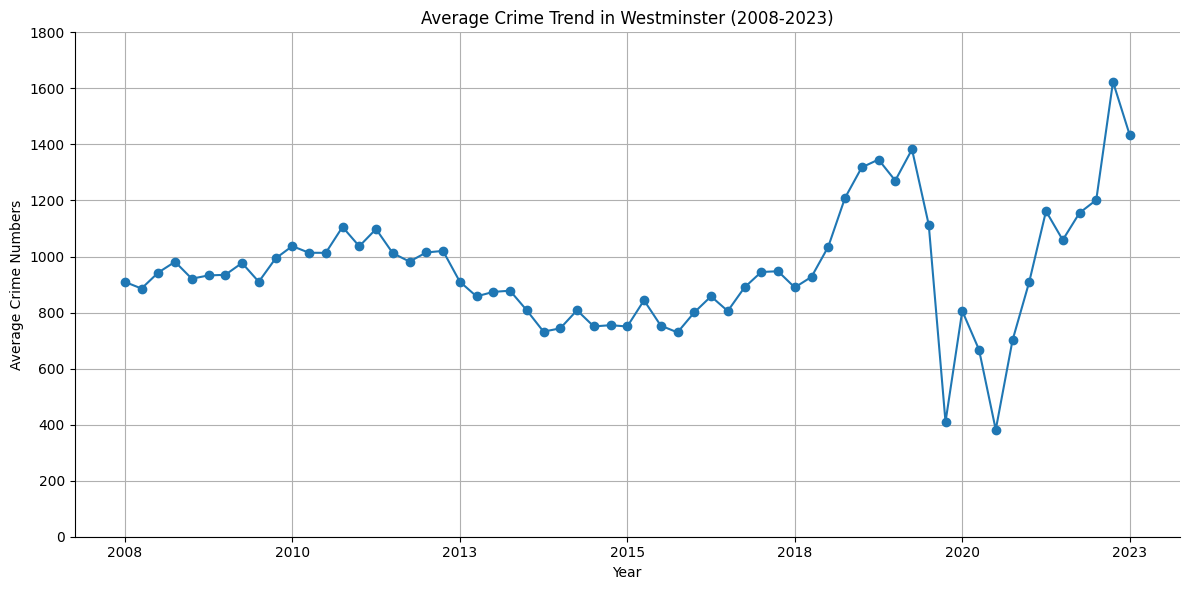

In [31]:
# Despite most London boroughs experiencing a constant crime level, Westminster has seen the highest fluctuations
# To plot the crime-price paid trends, we have first plotted average crime:
# in Westminster between 2008 and 2023
# Extract columns with crime levels
crime_columns = [col for col in merged_data_filtered.columns if col.endswith('_crime')]

# Extract relevant columns (LookUp_BoroughName and crime columns)
selected_columns = ['LookUp_BoroughName'] + crime_columns
selected_data = merged_data_filtered[selected_columns]

# Group by borough and calculate the average crime level for each borough
average_crime_by_borough = selected_data.groupby('LookUp_BoroughName').mean()

# Transpose the DataFrame for better visualization
average_crime_by_borough_transposed = average_crime_by_borough.transpose()

# Plot the average crime levels for Westminster between 2008 and 2023
westminster_crime = average_crime_by_borough_transposed['Westminster']

# Extract years from column names
years = [col.split('_')[0] for col in westminster_crime.index]
westminster_crime.index = years # Set the index to only show years

# Generate the plot
ax = westminster_crime.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Average Crime Trend in Westminster (2008-2023)')
plt.xlabel('Year')
plt.ylabel('Average Crime Numbers')
plt.grid(True)
plt.tight_layout()
sns.despine()

# Set y-axis range between 0 and 1750
ax.set_ylim([0,1800])

# Format x-axis labels to remove quarters for readability
ax.set_xticklabels([label.get_text().split('Q')[0] for label in ax.get_xticklabels()])

plt.show()

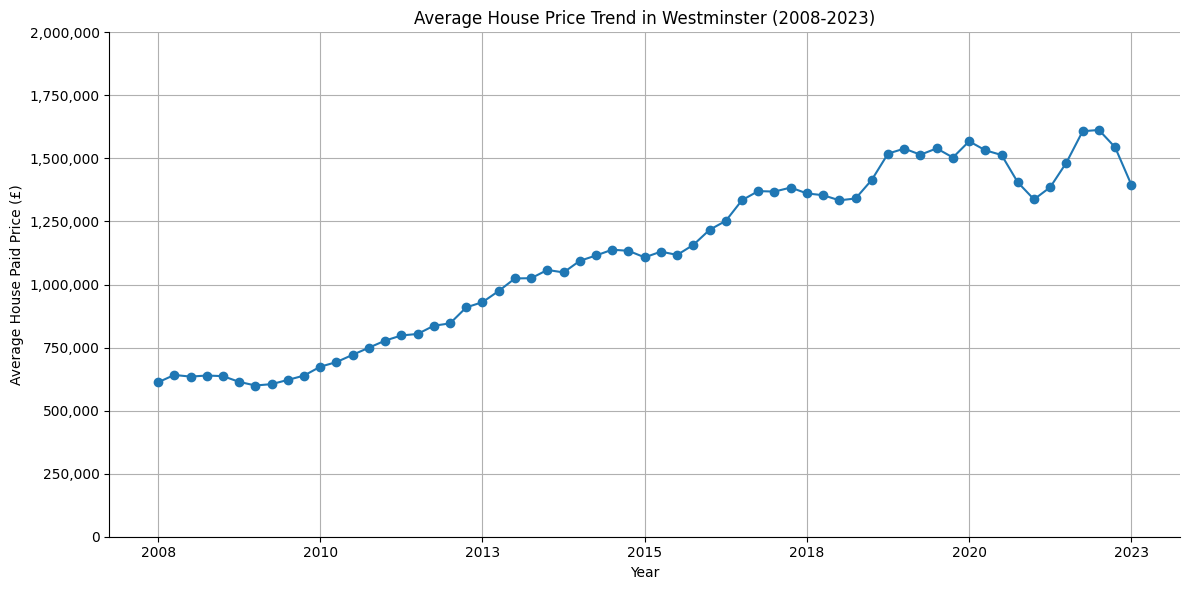

In [33]:
# Then, we plotted the average house price-paid in Westminster for the same period
# Extract columns with prices
price_columns = [col for col in merged_data_filtered.columns if col.endswith('_price')]

# Extract relevant columns (LookUp_BoroughName and price columns)
selected_columns = ['LookUp_BoroughName'] + price_columns
selected_data = merged_data_filtered[selected_columns]

# Group by borough and calculate the average price for each borough
average_prices_by_borough = selected_data.groupby('LookUp_BoroughName').mean()

# Transpose the DataFrame for better visualization
average_prices_by_borough_transposed = average_prices_by_borough.transpose()

# Plot the average prices for Westminster between 2008 and 2023
westminster_prices = average_prices_by_borough_transposed['Westminster']

# Extract years from column names
years = [col.split('_')[0] for col in westminster_prices.index]
westminster_prices.index = years  # Set the index to only show years

# Generate the plot
ax = westminster_prices.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Average House Price Trend in Westminster (2008-2023)')
plt.xlabel('Year')
plt.ylabel('Average House Paid Price (£)')
plt.grid(True)
sns.despine()

# Set y-axis range between 0 and 2,000,000
ax.set_ylim([0, 2000000])

# Format y-axis labels as integers
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Format x-axis labels to remove quarters for readability
ax.set_xticklabels([label.get_text().split('Q')[0] for label in ax.get_xticklabels()])

plt.tight_layout()
plt.show()

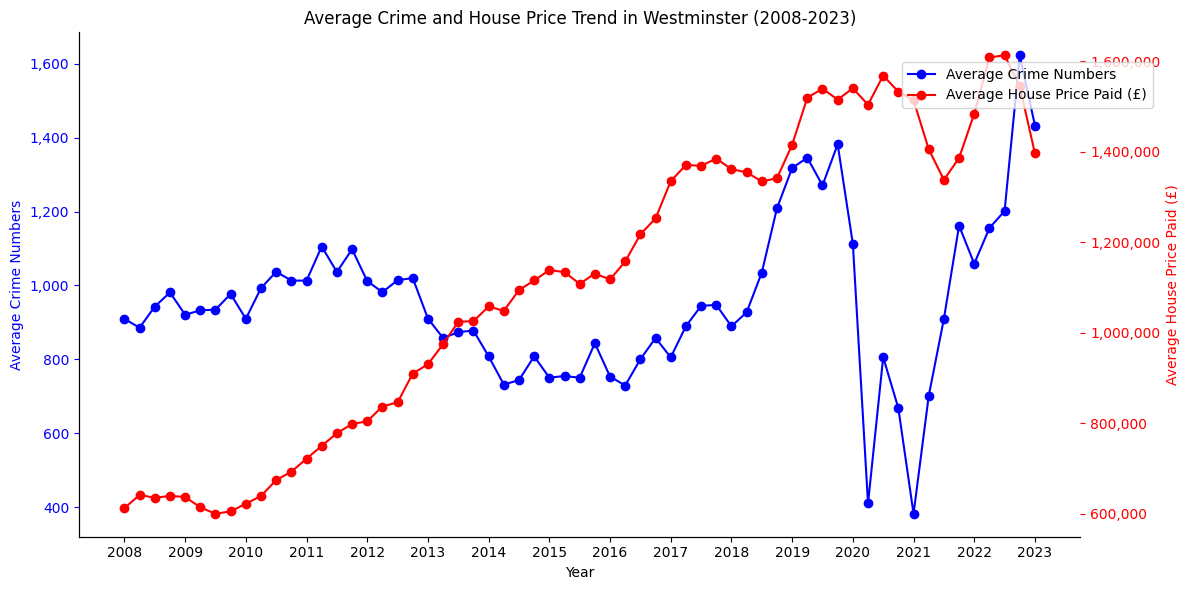

In [34]:
# Lastly, combine the two visualisations to observe the crime-price Westminster trends
# Extract columns with prices
price_columns = [col for col in merged_data_filtered.columns if col.endswith('_price')]

# Extract columns with crime levels
crime_columns = [col for col in merged_data_filtered.columns if col.endswith('_crime')]

# Extract relevant columns (LookUp_BoroughName, price columns, and crime columns)
selected_columns = ['LookUp_BoroughName'] + price_columns + crime_columns
selected_data = merged_data_filtered[selected_columns]

# Filter data for Westminster
westminster_data = selected_data[selected_data['LookUp_BoroughName'] == 'Westminster']

# Plot both average crime levels and average prices on one graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract years for x-axis
years = westminster_data[price_columns].columns.str.split('_').str[0]

# Plot average crime levels on the primary y-axis
ax1.plot(
    years,
    westminster_data[crime_columns].mean(axis=0),
    color='b', marker='o', label='Average Crime Numbers'
)
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Crime Numbers', color='b')
ax1.tick_params('y', colors='b')
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Create a secondary y-axis for average prices
ax2 = ax1.twinx()
ax2.plot(
    years,
    westminster_data[price_columns].mean(axis=0),
    color='r', marker='o', label='Average House Price Paid (£)'
)
ax2.set_ylabel('Average House Price Paid (£)', color='r')
ax2.tick_params('y', colors='r')
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Set x-axis ticks to show only each year
ax1.set_xticks(ax1.get_xticks()[::4])  # Adjust the step as needed

# Format x-axis labels to remove quarters for readability
ax1.set_xticklabels([label.get_text().split('Q')[0] for label in ax1.get_xticklabels()])

# Add title and legend
plt.title('Average Crime and House Price Trend in Westminster (2008-2023)')
sns.despine()
fig.tight_layout()

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.75, 0.9))

plt.show()

Nonetheless, since there appears to be no clear inverse relationship between crime rates (which have fluctuated) and price paid (which hasgenerally increased over the past 15 years) in any of the two boroughs, one may use a prediction model and deeper statistical analysis todetermine an association.

## 6. Predictive Models

## 6.1 Linear Regression Model

In [35]:
# Uploaded the merged_data_filtered.csv
df = pd.read_csv('merged_data_filtered.csv')
print(df.head())

     LookUp_BoroughName   WardCode        WardName  2008Q1_price  \
0  Barking and Dagenham  E05000026           Abbey     183503.54   
1  Barking and Dagenham  E05000027          Alibon     186748.63   
2  Barking and Dagenham  E05000033      Goresbrook     192907.23   
3  Barking and Dagenham  E05000036      Mayesbrook     190229.47   
4  Barking and Dagenham  E05000029  Chadwell Heath     208404.86   

   2008Q1_crime  2008Q2_price  2008Q2_crime  2008Q3_price  2008Q3_crime  \
0         828.0     185865.29         863.0     188033.36         836.0   
1         258.0     189166.93         222.0     190668.53         230.0   
2         221.0     187726.92         235.0     183495.59         254.0   
3         239.0     192776.85         260.0     189357.11         231.0   
4         300.0     209918.42         284.0     207978.62         289.0   

   2008Q4_price  ...  2022Q1_price  2022Q1_crime  2022Q2_price  2022Q2_crime  \
0     180628.24  ...     284981.87         579.0     267432.

In [36]:
# Changing the shape of the data table
# Turning from wide style to long stype with more rows and less columns
# Long format is easier to conduct statistical analysis
df_long = df.melt(id_vars =['LookUp_BoroughName', 'WardCode', 'WardName'],
var_name='Year_Quarter', value_name ='Value')

# Split the 'Year_Quarter' into two columns: one for year and one for quarter
df_long[['Year', 'Quarter']] = df_long['Year_Quarter'].str.extract(r'(\d{4})Q(\d)')

# Separate out the price and crime columns
df_prices = df_long[df_long['Year_Quarter'].str.contains('price')].rename({'Value': 'Price'}, axis=1)
df_crime = df_long[df_long['Year_Quarter'].str.contains('crime')].rename({'Value': 'Crime'}, axis=1)

# Drop the 'Year_Quarter' column as we no longer need it
# Data is already separated into 'Year' and 'Quarter'
df_prices = df_prices.drop('Year_Quarter', axis=1)
df_crime = df_crime.drop('Year_Quarter', axis=1)

# Merge the price and crime dataframes on borough, ward, year, and quarter
df_merged = pd.merge(df_prices, df_crime, on=['LookUp_BoroughName', 'WardCode', 'WardName', 'Year', 'Quarter'])

# The dependent variable (y) is price, and the independent variable (x) is crime
y = df_merged['Price']
X = df_merged[['Crime']]

# Add a constant to the model (the intercept term)
# Presents the base house prices before accounting for crime values
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     3454.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:34:10   Log-Likelihood:            -3.2346e+05
No. Observations:               23058   AIC:                         6.469e+05
Df Residuals:                   23056   BIC:                         6.469e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.949e+05   2588.869    152.531      0.0

As linear regressions are unable to capture complexities, a polynomial regression test was next conducted to explore the non-linearity between price and crime.

## 6.2 Polynomial Regression Model

In [37]:
# Generate polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
model = sm.OLS(y, X_poly).fit()

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     1882.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:34:59   Log-Likelihood:            -3.2333e+05
No. Observations:               23058   AIC:                         6.467e+05
Df Residuals:                   23055   BIC:                         6.467e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.459e+05   1221.512    119.451      0.0

Lastly, a Robust Linear Model (RLM) was conducted to minimise the influence of outliers and test the validity of the tested relationship.

### 6.3 Robust Linear Regression

In [38]:
# Robust Linear Model
# Fit the robust regression model
model = RLM(y, X, M=sm.robust.norms.HuberT())
huber_model = model.fit()

# Print out the statistics
print(huber_model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  Price   No. Observations:                23058
Model:                            RLM   Df Residuals:                    23056
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 12 Sep 2024                                         
Time:                        15:35:40                                         
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.877e+05   1819.976    213.045      0.0

## 7. Conclusions